In [244]:
from bert_embedding import BertEmbedding
  
import numpy as np 
import pandas as pd
  
from sklearn import cluster
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [245]:
CITY = 'sydney'

In [246]:
def zomatoPreprocess(city):
    #Zomato preprocessing

    zomato = pd.read_csv('data/'+city+'.csv')
    zomato = zomato[['name','cuisines']].dropna(axis=0)

    cuisines = zomato.cuisines.apply(lambda x:x.replace('[','')
                                                .replace(']','')
                                                .replace('"','')
                                                .replace(',',' ')
                                                .replace('and','') + ' food'
                                                .replace('  ',' '))

    names = zomato.name.values
    
    return cuisines, names

# BERT: Bidirectional Encoder Representations from Transformers

#### Abstract:

We introduce a new language representation model called BERT, which stands for Bidirectional Encoder Representations from Transformers. Unlike recent language representation models, BERT is designed to pre-train deep bidirectional representations by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT representations can be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial task-specific architecture modifications. BERT is conceptually simple and empirically powerful. It obtains new state-of-the-art results on eleven natural language processing tasks, including pushing the GLUE benchmark to 80.4% (7.6% absolute improvement), MultiNLI accuracy to 86.7 (5.6% absolute improvement) and the SQuAD v1.1 question answering Test F1 to 93.2 (1.5% absolute improvement), outperforming human performance by 2.0%.

.

###### This notebook uses the bert-embeddings pypi package which builds off of gluon-nlp https://pypi.org/project/bert-embedding/

.

In [247]:
def stack(embeddings,stacked=[],n=0):

    if len(stacked)>0: x = stacked
    else: x = embeddings[0]
    
    try:stacked = np.add(np.array(x), embeddings[1])
    except:return np.array(x)
    
    n += 1
    
    return stack(embeddings[1:],stacked=stacked,n=n)



def __bagofBERTs(restaurants,berts):
    
    output = []
    
    for restaurant,(cuisines,embeddings) in zip(restaurants,berts):
        embedding = stack(embeddings)
        output += [(restaurant,cuisines,embedding)]
        
    return output



def getEmbeddings(n_restaurants=100,city=CITY):
    
    print('Cleaning Zomato data for {}.\n'.format(city))
    cuisines, names = zomatoPreprocess(CITY.lower())
    
    print('Retrieving BERT sentence representations for {} restuarants...\n'.format(n_restaurants))
    __bert_embedding = BertEmbedding(model='bert_12_768_12')
    __berts = __bert_embedding(cuisines[:n_restaurants])
    bagofembeddings = __bagofBERTs(names, __berts)
    
    print('Complete.')
    
    filtrd = [(n,c,e) for n,c,e
              in bagofembeddings 
                  if len(e.shape)>0]

    cuisines = [c for n,c,e in filtrd]
    embeds = [e for n,c,e in filtrd]
    names = [n for n,c,e in filtrd]
    
    return names,cuisines,embeds,bagofembeddings
    

In [253]:
names, cusines, embeds, bag = getEmbeddings(n_restaurants=1000)

Cleaning Zomato data for sydney.

Retrieving BERT sentence representations for 1000 restuarants...

Complete.


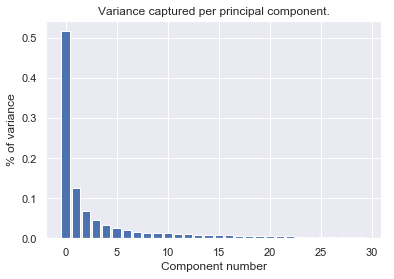

In [273]:
pca = PCA(n_components=30)
principal_components = pca.fit_transform(embeds)

pca0 = principal_components[:,0]
pca1 = principal_components[:,1]
pca2 = principal_components[:,2]

summed = sum(pca.explained_variance_)

plt.bar(range(len(pca.explained_variance_)),[i/summed for i in (pca.explained_variance_)])
plt.title('Variance captured per principal component.')
plt.ylabel('% of variance')
plt.xlabel('Component number')
plt.show()

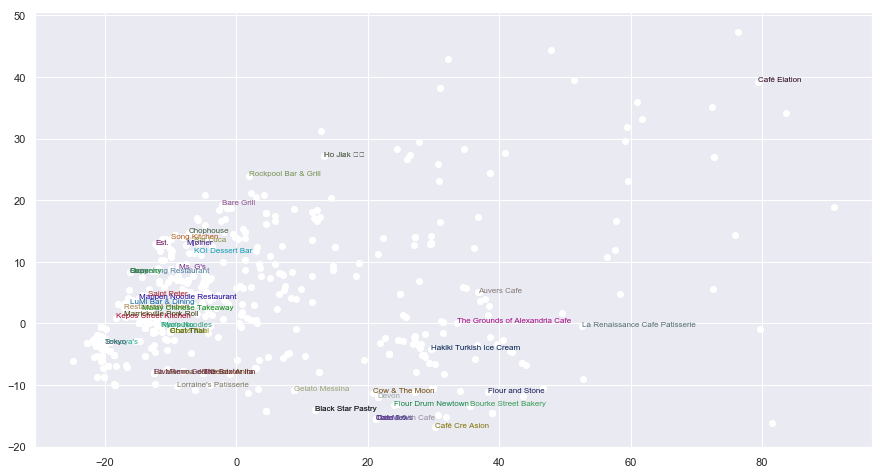

In [293]:
plt.figure(figsize=(15,8))
plt.scatter(pca0,pca1,c='white')
for i, x, y in zip(names, pca0[:50], pca1[:50]):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=8)
plt.show()

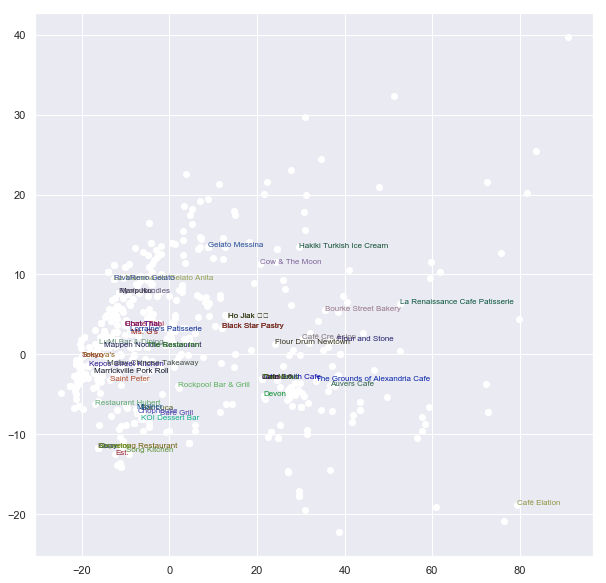

In [292]:
plt.figure(figsize=(10,10))
plt.scatter(pca0,pca2,c='white')
for i, x, y in zip(names, pca0[:50], pca2[:50]):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=8)
plt.show()

#### Kmeans clustering over 1000 restaurants

In [304]:
def plot_label_dist(cluster,palette='inferno',figsize=(10,5),flip_axes=False):
    labels = sorted(cluster.labels_.astype(float))
    Y = [labels.count(x) for x in set(labels)]
    X = list(set(labels))
    
    plt.figure(figsize=figsize)
    if flip_axes: sns.barplot(Y,X,palette=palette)
    else: sns.barplot(X,Y,palette=palette)
    plt.xlabel('Cluster label')
    plt.ylabel('# of member restaurants')

    plt.title('distribution across {} clusters'.format(len(set(labels))))
    plt.show()
    

def plot_clusters(cluster
                  ,pc=principal_components
                  ,text=False
                  ,n_names=10
                  ,centroids=False
                  ,figsize=(6,6)
                  ,multiple_plots=False):
    sns.set()
    pca0 = pc[:,0]
    pca1 = pc[:,1]
    pca2 = pc[:,2]
    
    if centroids: centroid_plot = cluster.cluster_centers_
    n = 2 if multiple_plots else 1
    for i,other_pc in enumerate([pca1,pca2][:n]):
        count=0
        
        plt.figure(figsize=figsize)
        plt.scatter(x=pca0,y=other_pc
                    ,c=kmeans.labels_.astype(float)
                    , s=50
                    , alpha=0.5)
        if centroids: plt.scatter(centroid_plot[:,0], centroid_plot[:,1], c='blue', s=50)
        
        #Add merchant name annontations
        if text:
            for n, (j, x, y) in enumerate(zip(names, pca0, other_pc)):
                if count>n_names: break
                if np.random.rand(1)[0]>0.5:
                    count+=1
                    
                    xytexts = [+3,-3,+5,-5,+7,-7]
                    xco = np.random.choice(xytexts); yco = np.random.choice(xytexts)

                    plt.annotate(j, xy=(x, y),xytext=(x+xco, y+yco),fontsize=10,
                        arrowprops=dict(facecolor=np.random.rand(3), shrink=0.05),)

        plt.title('component0 and component{}'.format(i))
        plt.show()

def plot_3d_clusters(clusters
                     ,text=False
                     ,n_names=8
                     ,pc=principal_components
                     ,figsize=(6,6)):
    from mpl_toolkits.mplot3d import Axes3D
    np.random.seed(5)

    X = pc[:,0]
    Y = pc[:,1]
    Z = pc[:,2]

    fignum = 1

    for name,est in clusters:
        count=0
        fig = plt.figure(fignum, figsize=figsize)
        ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

        ax.scatter(X, Y, Z,
                   c=est.labels_.astype(float), edgecolor='k')

        ax.w_xaxis.set_ticklabels([])
        ax.w_yaxis.set_ticklabels([])
        ax.w_zaxis.set_ticklabels([])
        ax.set_xlabel('component0')
        ax.set_ylabel('component1')
        ax.set_zlabel('component2')
        ax.set_title(name)
        ax.dist = 12
        fignum = fignum + 1
        
    
    
    if text:
        for n, (j, x, y, z) in enumerate(zip(names, X,Y,Z)):
            if count>n_names: break
            if np.random.rand(1)[0]>0.5:
                count+=1

                xytexts = [+3,-3,+5,-5,+7,-7]
                xco = np.random.choice(xytexts); yco = np.random.choice(xytexts)

                plt.annotate(j, xy=(x, y),xytext=(x+xco, y+yco),fontsize=10,
                    arrowprops=dict(facecolor=np.random.rand(3), shrink=0.05),)

    fig.show()    


In [277]:
#names, cusines, embeds = getEmbeddings(1000)

In [ ]:
pca = PCA(n_components=30)
principal_components = pca.fit_transform(embeds)

#### Kmeans

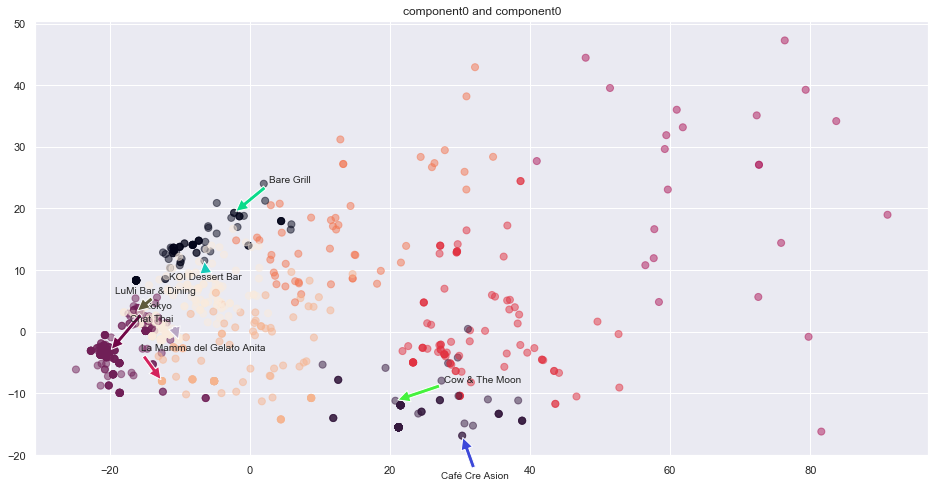

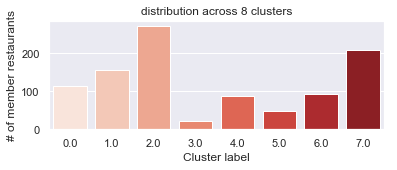

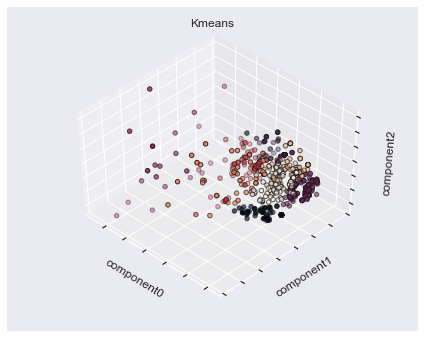

In [309]:
kmeans = cluster.KMeans(n_clusters=8).fit(embeds)
plot_clusters(kmeans,text=True,n_names=7,figsize=(16,8))
plot_label_dist(kmeans,palette='Reds',figsize=(6,2))
plot_3d_clusters([('Kmeans',kmeans)],figsize=(6,4.5))

#### Kmeans++

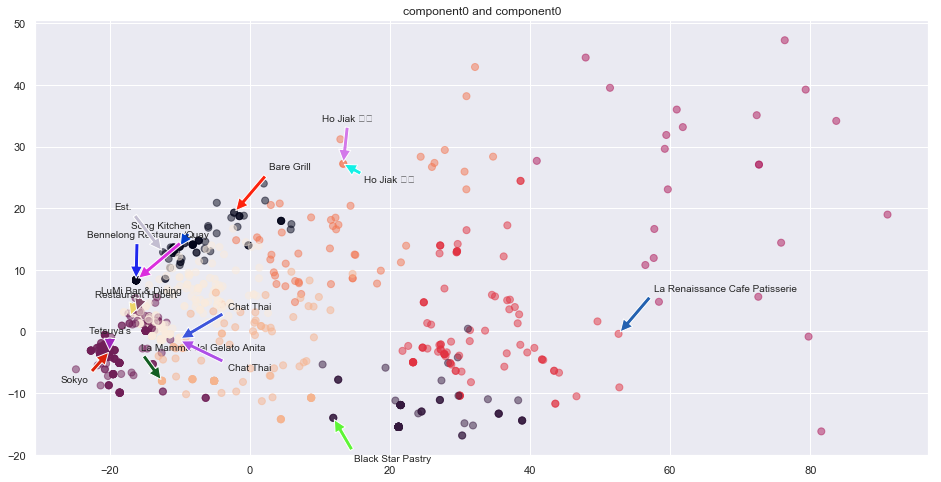

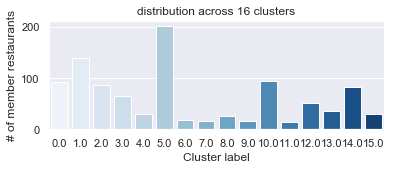

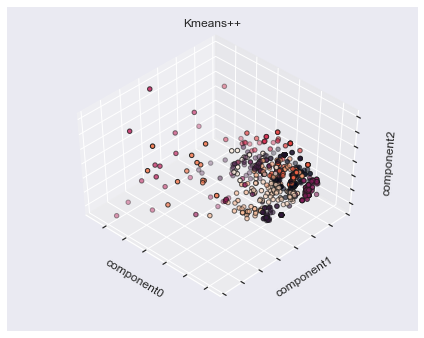

In [311]:
kplus = cluster.KMeans(n_clusters=16,init='k-means++').fit(embeds)
plot_clusters(kplus,text=True,n_names=15,figsize=(16,8))
plot_label_dist(kplus,palette='Blues',figsize=(6,2))
plot_3d_clusters([('Kmeans++',kplus)],figsize=(6,4.5))

#### Affinity Propagation

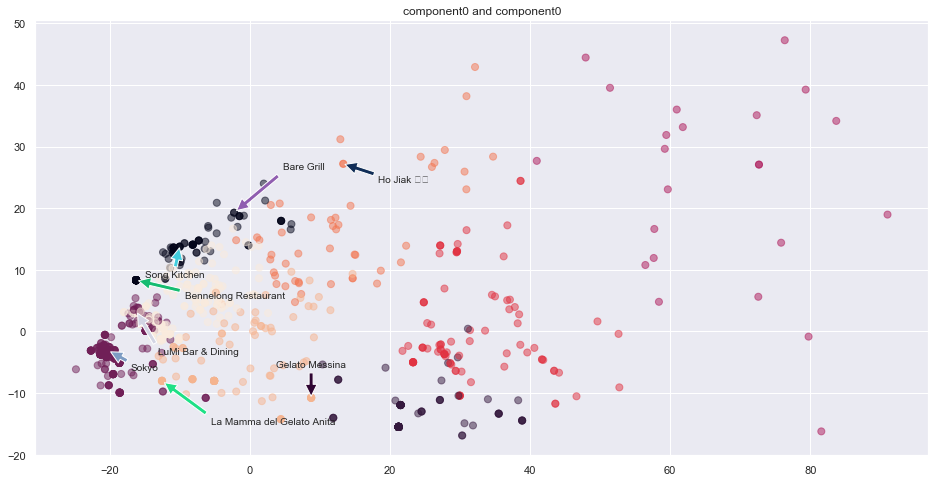

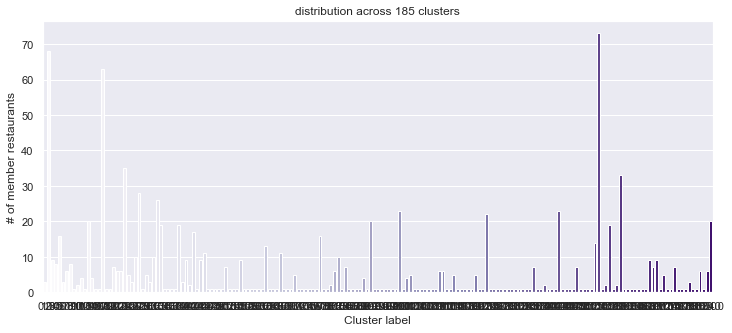

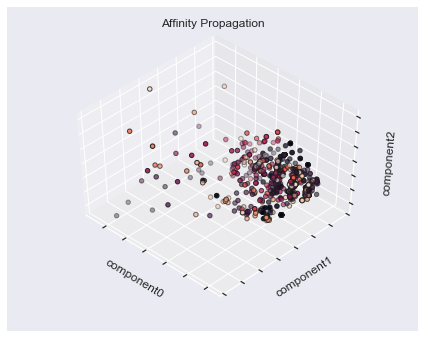

In [310]:
##### affiProp = cluster.AffinityPropagation().fit(embeds)
plot_clusters(affiProp,text=True,n_names=7,figsize=(16,8))
plot_label_dist(affiProp,palette='Purples',figsize=(12,5),flip_axes=False)
plot_3d_clusters([('Affinity Propagation',affiProp)],figsize=(6,4.5))